# Career Booster Python & Data Science

## Session 3 : Introduction aux arbres de décision

*** 

Ce notebook représente une introduction aux [*arbres de décision*][1] sur la base du jeu de données [*Titanic*][2] déjà abordé à la session précédente (cf. fichier CB_DSP_S2.ipynb). Ce notebook est une adaptation de l'excellent notebook de [Diego Milla][3], et se basant également sur ceux de [Sina][4], [Anisotropic][5] et [Megan Risdal][6].


[1]: https://en.wikipedia.org/wiki/Decision_tree_learning
[2]: https://www.kaggle.com/c/titanic/overview
[3]: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
[4]: https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier
[5]: https://www.kaggle.com/arthurtok/titanic/introduction-to-ensembling-stacking-in-python
[6]: https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic

## Import des bibliothèques

In [63]:
import numpy as np
import pandas as pd
import re  # expressions régulières
from subprocess import check_call  # pour exécuter des commandes dans le terminal

# --- Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont

# --- Machine Learning
import xgboost as xgb
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## A. Préparation du jeu de données

### 1. Import des données

In [64]:
path_to_files = "../data/titanic"

# --- Jeu de données d'entraînement
train = pd.read_csv(path_to_files + '/train.csv')

# --- Jeu de données test
test = pd.read_csv(path_to_files + '/test.csv')

passenger_id = test['PassengerId']

Un coup d'œil sur nos données :

In [65]:
# --- Jeu de données d'entraînement
train.head(5)
#train.sample(5)

# --- Jeu de données de test
#test.head(5)
#test.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Nous constatons là plusieurs choses :

1. La colonne "*Survived*" est déjà exprimée de façon binaire (0 ou 1) et ne nécessite donc pas de travail supplémentaire
2. La colonne "*Ticket*" semble contenir des valeurs avec différents formats
3. La colonne "*Cabin*" semble contenir beaucoup de valeurs manquantes (NaN)
4. La colonne "*Name*" va devoir être traitée 
5. Il va sûrement être possible de regrouper certaines colonnes (comme "*SibSp*" et "*Parch*")

### 2. Nettoyage des données

In [66]:
# --- On garde une copie du dataset original, au cas où
original_train = train.copy()

# On crée un jeu de données regroupant les jeux de données test et train
full_data = [train, test]

#### Création de colonnes supplémentaires

On crée une colonne *Has_Cabin*.
Cela permettra de dropper la colonne *Cabin*, non informative telle quelle.

In [67]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

On crée une colonne *FamilySize* qui est la somme de *SibSp* et *Parch*

In [68]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

On crée également une colonne *IsAlone*

In [69]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

#### Remplacement des valeurs nulles

On remplace les valeurs nulles de la colonne "Embarked" par la valeur "S" (Southampton)

In [70]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

On remplace les valeurs nulles de la colonne "Fare" par la médiane de la colonne

In [71]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

On remplace les valeurs nulles de la colonne "Age" par une valeur aléatoire comprise entre moy - std et moy + std.

Il existe plein d'autres méthodes.

In [72]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

On crée une fonction permettant de récupérer le Titre (M., Mme, Dr. etc.) de la personne dont le nom figure sur le ticket. On utilise cette fonction pour la création d'une colonne "Title" dédiée.

In [73]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

Certains titres sont assez rares ou particuliers. On les regroupe en une seule dénomination : "Rares"

On remplace également les titres en français par ceux en anglais.


In [74]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [75]:
dataset["Title"]

0          Mr
1         Mrs
2          Mr
3          Mr
4         Mrs
        ...  
413        Mr
414      Rare
415        Mr
416        Mr
417    Master
Name: Title, Length: 418, dtype: object

On réalise ici des *mappings* de valeurs afin de transformer les variables non catégorielles (comme l'âge) en variables catégorielles.

Cela permet de faciliter l'apprentissage du modèle.

In [76]:
for dataset in full_data:
    # --- Mapping de la colonne "Sex"
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # --- Mapping de la colonne "Title"
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # --- Mapping de la colonne "Embarked"
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    # --- Mapping de la colonne "Fare" sur la base des valeurs de quartiles (cf. Notebook CB_DSP_S2)
    Q1 = dataset['Fare'].describe()["25%"]
    Q2 = dataset['Fare'].describe()["50%"]
    Q3 = dataset['Fare'].describe()["75%"]
    dataset.loc[dataset['Fare'] <= Q1, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > Q1) & (dataset['Fare'] <= Q2), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > Q2) & (dataset['Fare'] <= Q3), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > Q3, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # --- Mapping Age
    Q1 = dataset['Age'].describe()["25%"]
    Q2 = dataset['Age'].describe()["50%"]
    Q3 = dataset['Age'].describe()["75%"]
    dataset.loc[dataset['Age'] <= Q1, 'Age'] = 0
    dataset.loc[(dataset['Age'] > Q1) & (dataset['Age'] <= Q2), 'Age'] = 1
    dataset.loc[(dataset['Age'] > Q2) & (dataset['Age'] <= Q3), 'Age'] = 2
    dataset.loc[dataset['Age'] > Q3, 'Age'] = 3;

On peut désormais retirer certaines colonnes devenues inutiles.

In [77]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

## Corrélation

Nous allons ici observer s'il existe une corrélation entre certaines colonnes.
Cette corrélation signifie que deux colonnes sont potentiellement "liées".

Ci-dessous, une illustration de la signification du coefficient de [Pearson][1], permettant de caractériser la corrélation *linéaire* entre deux variables. Les données utilisées ont été générées pour l'illustration et ne correspondent pas à quoi que ce soit dans notre contexte.

Pour étudier une éventuelle corrélation non-linéaire, on utilisera le coefficient de [Spearman][2].

[1]: https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)
[2]: https://fr.wikipedia.org/wiki/Corr%C3%A9lation_de_Spearman

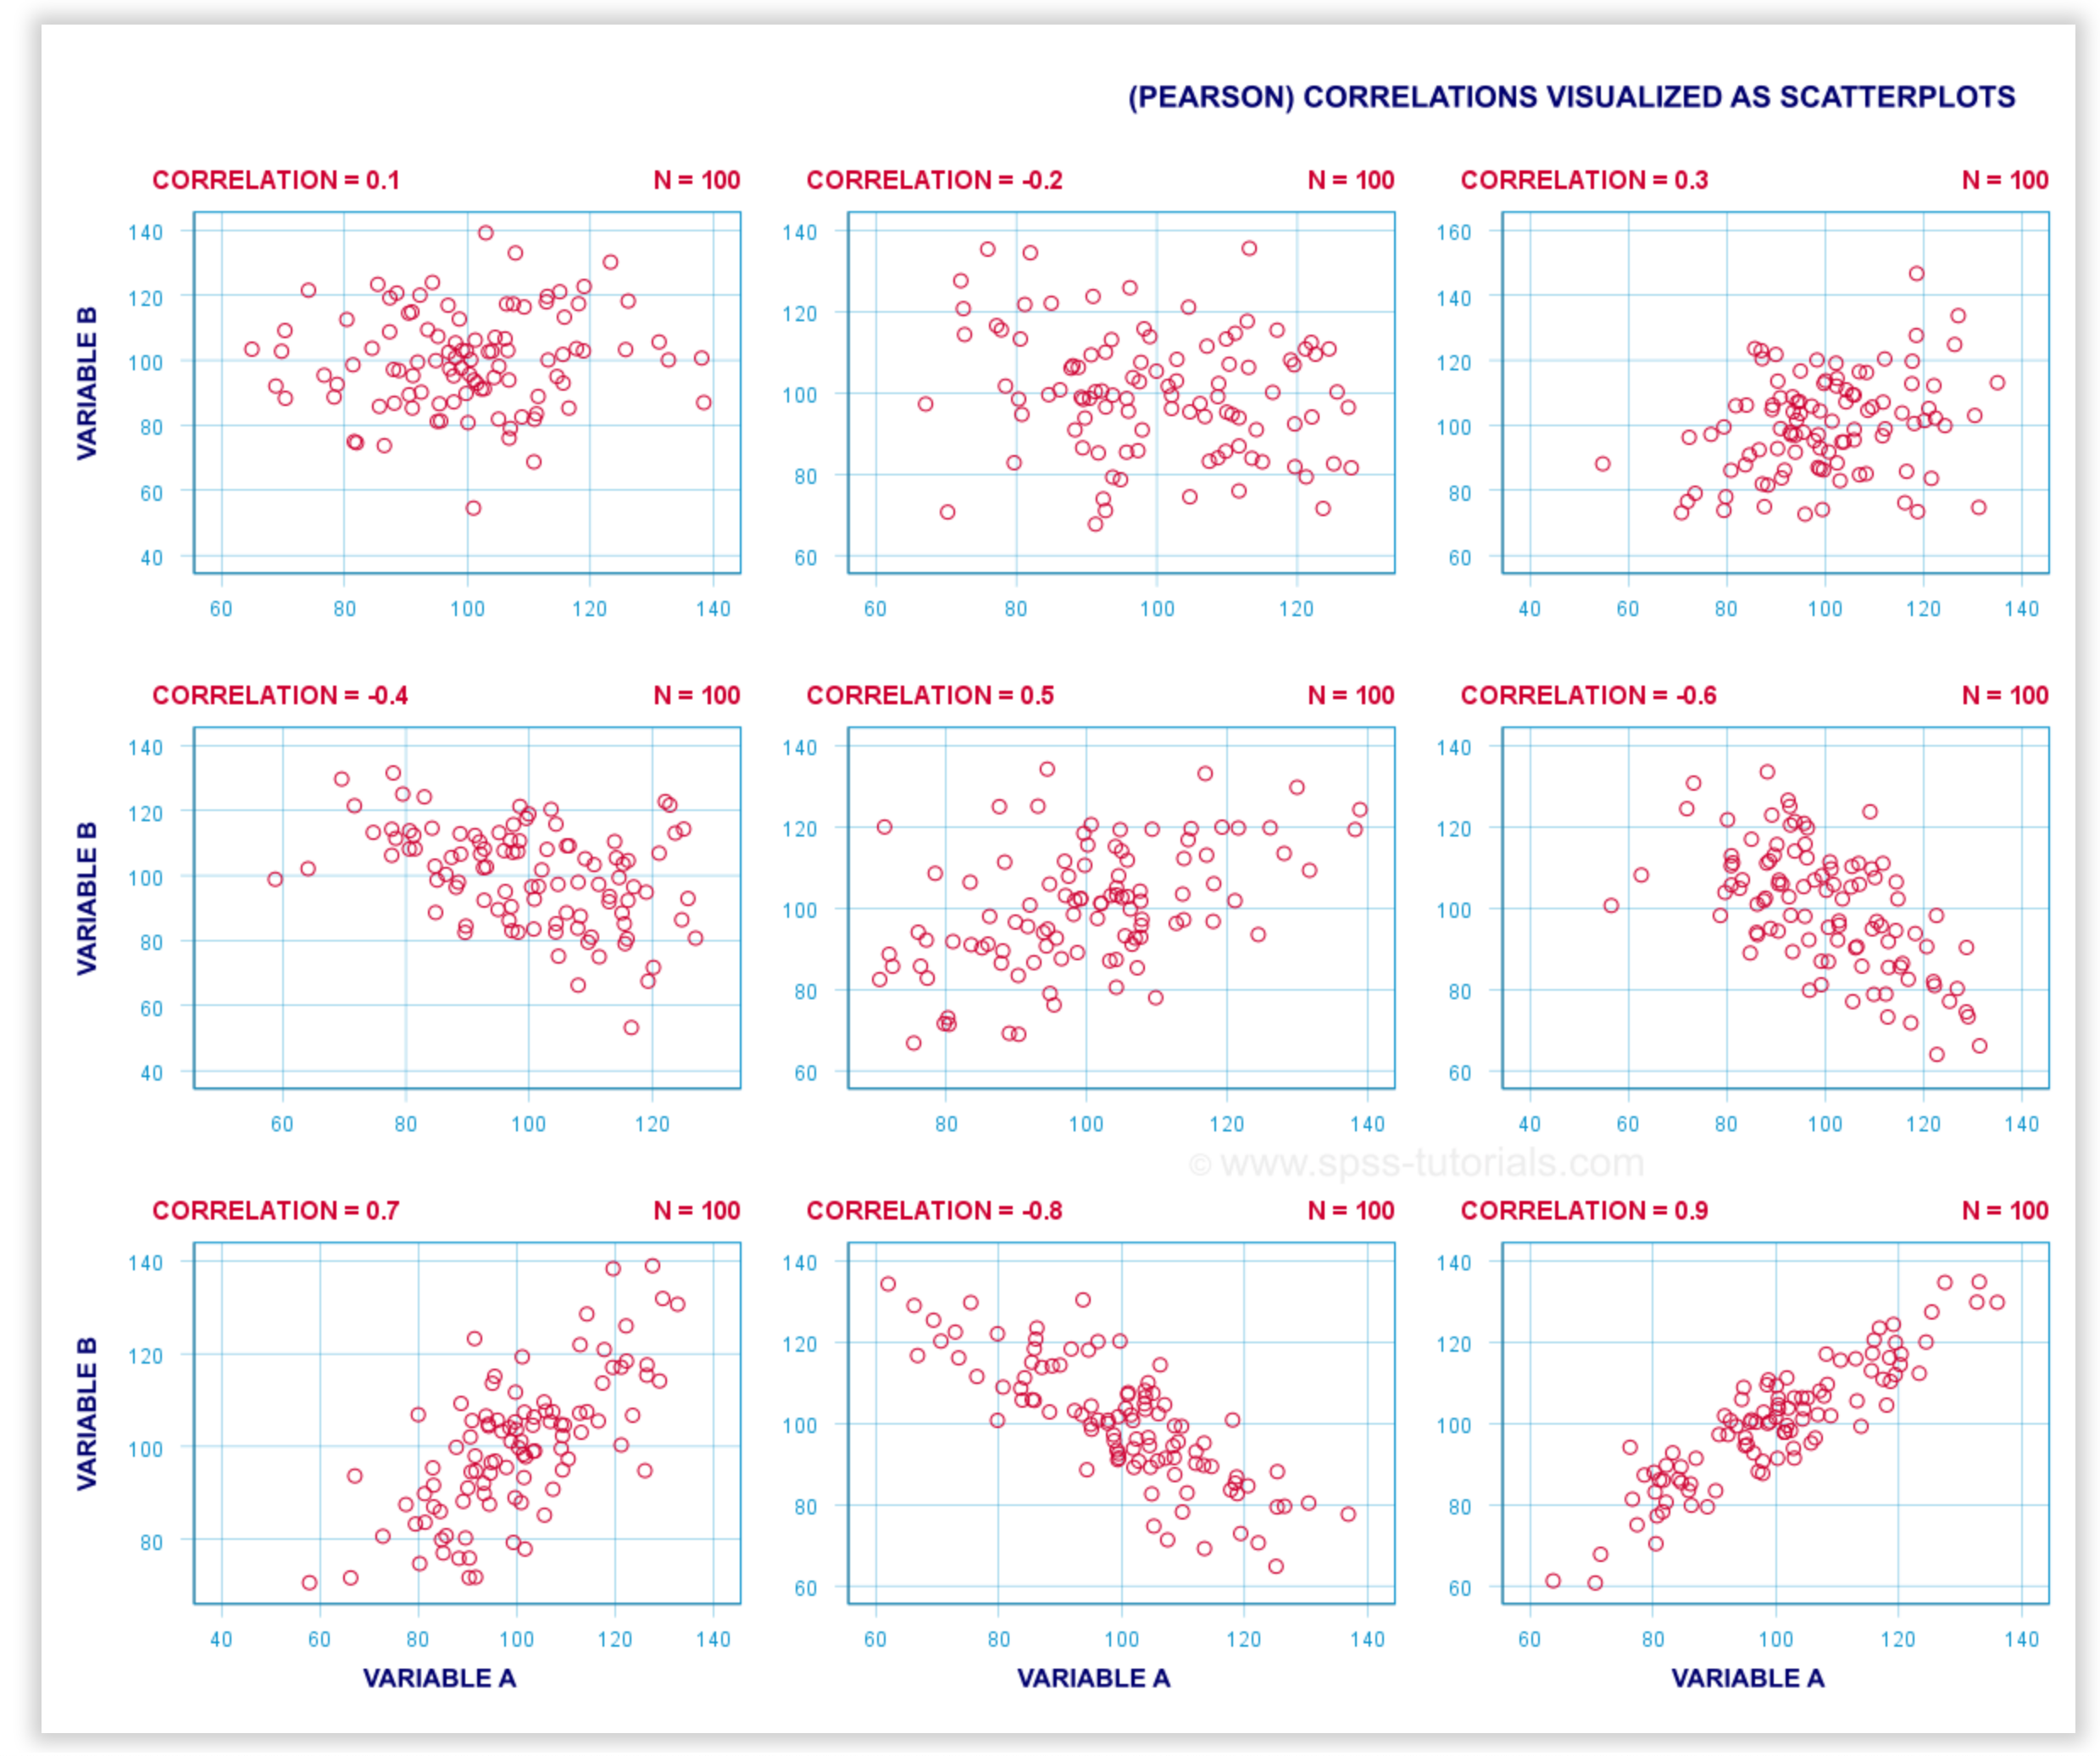

In [78]:
from IPython.display import Image as img
img(filename='../img/pearson_correlation.png')

***
Retour à nos données.

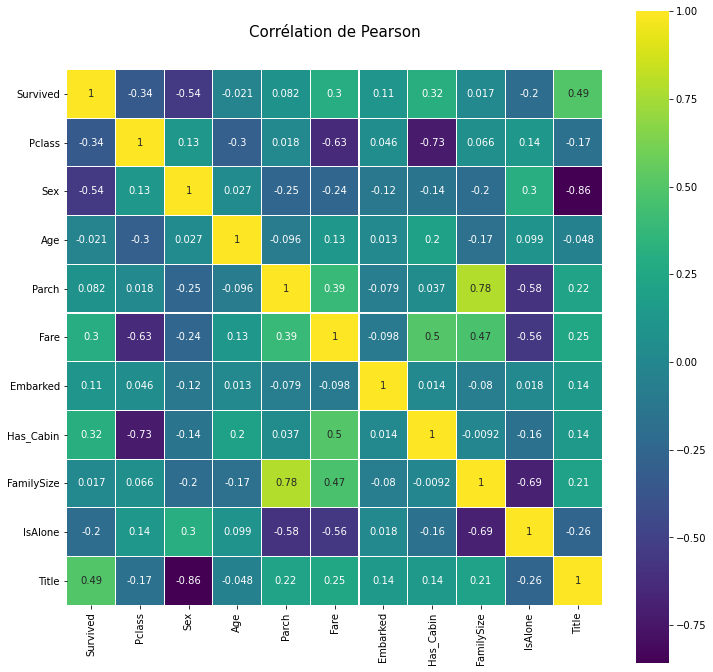

In [79]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12));
plt.title('Corrélation de Pearson', y=1.05, size=15)

sns.heatmap(train.astype(float).corr(), 
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True);

Cette matrice de corrélation, représentée sous forme de *heatmap* permet d'observer deux choses :
1. Les variables *Sex* et *Title* sont celles qui sont les plus fortement corrélées avec la variable cible *Survived*. Les valeurs sont respectivement -0.54 (corrélation négative) et 0.49 (corrélation positive)
2. La corrélation entre ces deux variables est également très forte (-0.86) indiquant que ces deux valeurs portent probablement la même information. Il faudra donc en supprimer une des deux afin de ne pas "polluer" le modèle en lui donnant deux variables trop proches. De plus, cette observation nous indique également que le premier nœud de notre arbre de décision correspondra à une de ces deux variables.

## B. Apprentissage

### 1. Détermination de l'arbre à la profondeur optimale
#### Validation croisée

L'idée de cette étape est de déterminer si tout le jeu de données est bien utile pour notre analyse. En effet, avoir beaucoup de données est souvent bien, mais en avoir *trop* peut être contre-productif. Notamment, on peut observer une mauvaise capacité du modèle à généraliser du fait d'un **sur-apprentissage**. Ce sur-apprentissage peut provenir d'un modèle mal configuré (i.e. d'un algorithme d'apprentissage mal calibré) ou d'un volume de données trop grand / complexe / mal pré-traité.

Dans notre cas, ce qui peut aboutir à un sur-apprentissage est la *profondeur* de l'arbre, c'est-à-dire combien de niveaux de décision vont être utilisés, sachant qu'à chaque niveau de décision correspond une variable /colonne du jeu de données à modéliser. Une manière efficace de déterminer la profondeur optimale est d'itérer sur le nombre de colonnes à utiliser et de mesurer la performance des différents modèles obtenus (démarche similaire à celle employée pour la méthode du coude dans l'algorithme des k-means). La mesure de cette performance sera faite selon la méthode de [validation croisée][1].

La validation croisée est une technique de validation d'un modèle basée sur un échantillonage du jeu de données d'entraînement en un certain nombre de blocs (*folds*), 10 dans notre cas. L'apprentissage comportera alors 10 itérations avec, à chaque itération, une sélection de 9 blocs pour l'entraînement et du bloc restant pour la validation. Cela permet de ne pas utiliser systématiquement le même jeu de données pour la validation et ainsi d'éviter d'éventuels biais d'apprentissage.


[1]: https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e

In [80]:
# --- Nombre de folds pour la validation croisée
cv = KFold(n_splits=10)

accuracies = list()

# --- Le nombre d'attributs est égal au nombre de variables utilisées en input (11 ici)
max_attributes = len(test.columns)

depth_range = range(1, max_attributes + 1)

# --- On effectue un apprentissage avec une profondeur différente à chaque fois
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    
    # --- Etape de cross validation
    for train_fold, valid_fold in cv.split(train):
        # Extract train data with cv indices
        f_train = train.loc[train_fold]

        # Extract valid data with cv indices
        f_valid = train.loc[valid_fold]

        # We fit the model with the fold train data
        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"])

        # We calculate accuracy with the fold validation data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])
        
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.814894
         5          0.817091
         6          0.807016
         7          0.799139
         8          0.803658
         9          0.795805
        10          0.789064


### 2. Arbre de décision final

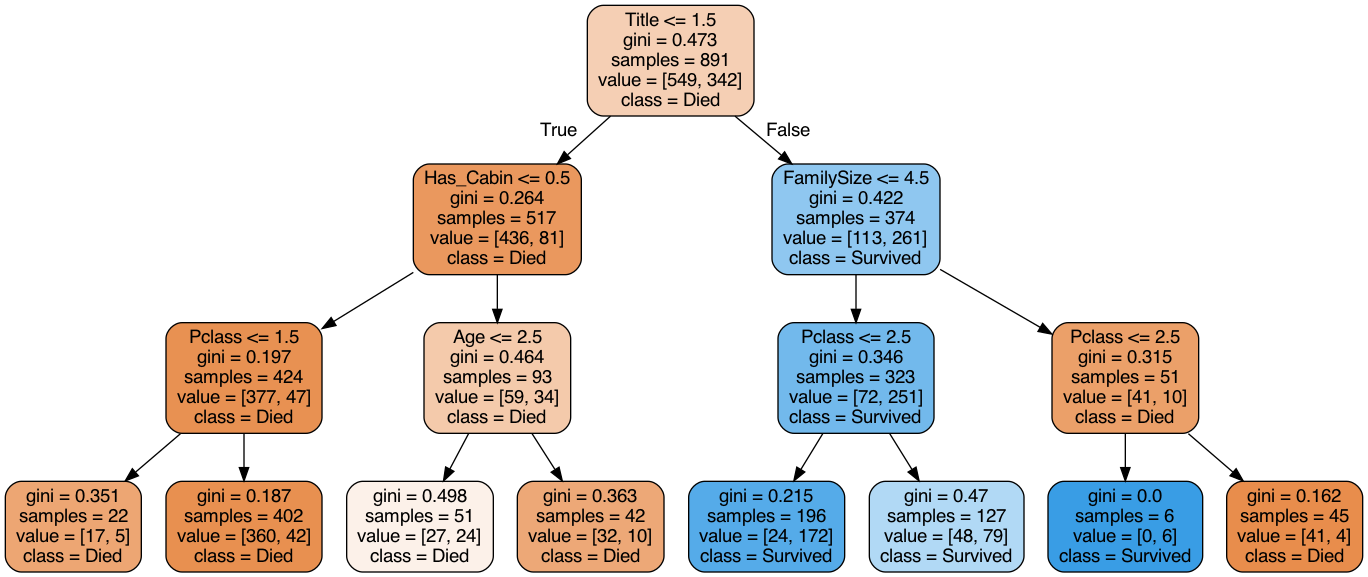

In [81]:
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values
y_test = 

depth = 3

decision_tree = tree.DecisionTreeClassifier(max_depth = depth)

decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(x_test)

#submission = pd.DataFrame({
#        "passenger_id": passenger_id,
#        "Survived": y_pred
#    })
#submission.to_csv('submission.csv', index=False)

# --- Export du modèle en tant que fichier .dot
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = depth,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
# --- Conversion du fichier .dot en .png afin de le visualiser ici
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

PImage("tree1.png")

# --- Annotating chart with PIL
#img = Image.open("tree1.png")
#draw = ImageDraw.Draw(img)
#draw.text((10, 0),
#          '"Title <= 1.5" correspond au titre "Mr."',
#          (0,0,255))
#img.save('sample-out.png')
#PImage("sample-out.png")

- La première ligne de chaque nœud, excepté pour la ligne finale, indique la règle de séparation : *variable* <= *valeur*.
- L'indice de Gini est ensuite indiqué (plus il est faible, mieux c'est).
- La valeur "samples" correspond au nombre d'observations passant par ce nœud.
- La ligne "value" représente la distribution des classes [non survécu, survécu]
- La ligne "class" correspond à la classe prédominante. Si une observation passe par ce nœud, cette classe lui sera assignée.


Ce modèle peut ainsi être résumé en 4 règles simples :

- Si *Title* = "Mr" : *not survived* (toutes les branches de la partie gauche pointent vers des nœuds en orange)
- Si *Title* autre que "Mr" et *FamilySize* inférieur à 4 : *survived*.
- Si *Title* autre que "Mr" et *FamilySize* est supérieur à 4 et *Pclass* inférieur à 2 : *survived*.
- Si *Title* autre que "Mr", et *FamilySize* est supérieur à 4 et *Pclass* supérieur à 2 : *non survived*

In [82]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(f"Précision (jeu de données test) : {acc_decision_tree}%")

Précision (jeu de données test) : 82.38%


## C. Conclusions

- Les personnes dont le titre était "Mister" ont manifestement respecté la fameuse règle du "*les femmes et les enfants d'abord !*"
- Les familles plus petites ont plus de chances de survivre
- Les personnes en 3è classe ont eu moins de chance de survivre, probablement parce que ces cabines étaient situées plus loin des radeaux de survie que les cabines des gens aisés.

## D. Random Forest

Un Random forest (ou [forêt d'arbres décisionnels][1]) est une collection d'arbres de décision. L'idée fondamentale repose sur le principe de "sagesse de la foule" (*wisdom of crowds*) : *un grand nombre d'avis peu experts sur un sujet peut s'avérer plus précis et pertinent que l'avis d'une seule personne, aussi experte soit-elle.*

L'idée est donc d'entraîner une grande variété d'arbres de décisions individuellement assez simples mais qui, mis ensemble, offrent une modélisation des données en entrée plus complète et précise.

[1]: https://fr.wikipedia.org/wiki/For%C3%AAt_d%27arbres_d%C3%A9cisionnels

In [100]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### 1. Création des jeux de données

On créé un jeu de données test et un train.
Nous n'allons pas faire de cross-validation ici mais libre à vous d'ajouter cette étape vous-même ! :)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    train.iloc[:, 1:],
    train.iloc[:, 0],
    test_size=0.17
)

### 2. Entraînement d'un premier Random Forest

Nous allons tout d'abord créer un random forest très simple :

In [103]:
rdmf = RandomForestClassifier(
    n_estimators=20,
    criterion='gini')

rdmf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20)

Observons son score sur le jeu de données d'apprentissage :

In [104]:
rdmf_score_tr = rdmf.score(X_train, y_train)
print(rdmf_score_tr)

0.9052774018944519


Puis sur le jeu de données de test :

In [105]:
rdmf_score = rdmf.score(X_test, y_test)
print(rdmf_score)

0.8157894736842105


La différence est importante : nous perdons beaucoup de précision sur nos prédictions sur des données que le modèle n'a jamais vu. Nous avons donc peut-être légèrement sur-appris les données d'apprentissage.

A noter cependant que les résultats sur les données test seront quasiment toujours moins bons que sur les données d'apprentissage (sinon, c'est qu'il y a eu un souci lors de l'apprentissage).

### 3. Création d'un second Random Forest

Il est également possible de spécifier des paramètres lors de la création de notre Random Forest. Il y en a un grand nombre et ils sont [listés ici][1]. Nous n'en utiliserons ici que quelques-uns, notamment :
- criterion : la mesure de la qualité (et de la convergence) de chaque arbre de décision
- n_estimators : le nombre d'arbres de la forêt
- min_samples_leaf : le nombre de samples minimum qu'un nœud doit posséder pour pouvoir justement être un nœud.

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [110]:
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(X_train, y_train)
print(rf.oob_score_)

0.8240866035182679


On obtient ici un score similaire au modèle créé précédemment, mais avec des paramètres différents... Ainsi, comment savoir quels paramètres sont les meilleurs ?

### 4. Grid Search

C'est là que nous allons effectuer l'étape d'optimisation du modèle (ou *hyperparameters tuning* ou aussi *fine tuning*), c'est-à-dire déterminer quels sont les paramètres optimaux pour obtenir le meilleur score possible. Nous allons ici utiliser la fonction GridSearchCV de sklearn qui, d'ailleurs, incorpore de la cross-validation.

#### a. Création du modèle

In [115]:
rf = RandomForestClassifier(max_features='auto')

#### b. Création de l'objet GridSearchCV

In [116]:
# --- Définition des paramètres à faire varier
param_grid = {
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 5, 10],
    "min_samples_split": [2, 4, 10, 12],
    "n_estimators": [20, 50, 100, 400, 700]
}

# --- Création de l'objet GridSearchCV qui sera utilisé sur le Random Forest
gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=-1
)

#### c. Entraînement du modèle

In [120]:
gs = gs.fit(X_train, y_train)

#### d. Evaluation

In [121]:
gs.best_score_

0.8335801554979637

Les meilleurs paramètres sont :

In [122]:
gs.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 20}

***
En addition ici, l'utilisation de XGBoost qui est un algorithme pour faire des Random Forest qui est (parfois) un plus puissant que l'algo classique.

In [133]:
### XG Boost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_score = xgb.score(X_train, y_train)
print(f"Train score: {xgb_score}")

xgb_score = xgb.score(X_test, y_test)
accuracies.append(xgb_score)
print(f"Test score: {xgb_score}")

Train score: 0.9012178619756428
Test score: 0.8223684210526315
